In [177]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd            
import seaborn as sns           
import sklearn     
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.special import gammainc
from sklearn.metrics import confusion_matrix
import scipy
import imblearn
from sklearn.preprocessing import normalize
sns.set_theme()
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Постановка задачи
Предоставлены данные, собранные в рамках рекламной кампании некоторого банка, в которой клиентам звонили с предложением сделать срочный вклад.

Цель: на основе данных о клиенте предсказать, будет ли он готов сделать вклад после рекламного звонка.

Источник данных: https://www.kaggle.com/kidoen/bank-customers-data

# Предобработка данных

## 1. Чтение данных

In [191]:
url = "https://raw.githubusercontent.com/KirillYashin/ML_Hometasks/master/BankCustomerData.csv"
data = pd.read_csv(url)

Строка - клиент.

Столбец - конкретный признак.

In [192]:
data.shape

(42639, 17)

In [193]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [194]:
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
42634,21,student,single,secondary,no,2488,no,no,telephone,12,jan,661,2,92,1,success,yes
42635,87,retired,married,primary,no,2190,no,no,telephone,12,jan,512,2,-1,0,unknown,yes
42636,34,blue-collar,married,primary,no,6718,no,no,cellular,13,jan,278,4,97,1,other,no
42637,22,student,single,secondary,no,254,no,no,cellular,13,jan,143,2,-1,0,unknown,yes
42638,32,management,single,tertiary,no,1962,no,no,cellular,13,jan,130,1,-1,0,unknown,no


Tаблица содержит данные о 42.6 тыс. клиентах банка и контакте с ними. Всего имеется 17 признаков:

- `age` - возраст
- `job` - профессия
- `marital` - семейное положение
- `education` - образование
- `balance` - остаток средств
- `default` - есть ли задолженность на кредитной карте
- `housing` - есть ли ипотечный кредит
- `loan` - есть ли кредит на личные цели
- `contact` - куда был произведён рекламный звонок
- `day/month` - день/месяц рекламного звонка
- `duration` - длительность звонка (Примечание: данный признак имеет прямое влияние на цель предсказания, нулевые по длительности разговоры автоматически означают отказ. При обучении модели его необходимо отбросить. )
- `campaign` - число звонков данному клиенту в рамках текущей рекламной кампании
- `pdays` - число дней со звонка по прошлой рекламной кампании (-1 если звонка по ней не было)
- `previous`- число звонков данному клиенту в рамках прошлой рекламной кампании
- `poutcome` - результат прошлой рекламной кампании 

Преобразуем тип соответствующих категориальных признаков в подходящий и рассмотрим индексы каждой категории:

In [195]:
for col in ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month','poutcome','term_deposit']:
    data[col] = data[col].astype('category')
    print(col)
    print(data[col].dtype.categories)
    print('-------------------------------')

job
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')
-------------------------------
marital
Index(['divorced', 'married', 'single'], dtype='object')
-------------------------------
education
Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
-------------------------------
default
Index(['no', 'yes'], dtype='object')
-------------------------------
housing
Index(['no', 'yes'], dtype='object')
-------------------------------
loan
Index(['no', 'yes'], dtype='object')
-------------------------------
contact
Index(['cellular', 'telephone', 'unknown'], dtype='object')
-------------------------------
month
Index(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov',
       'oct', 'sep'],
      dtype='object')
-------------------------------
poutcome
Index(['failure', 'other', 'success', 'unknown'], dtype=

По названиям индексов всё очевидно, кроме индекса 'other' в исходе предыдущей рекламной кампании. Найти описание данного индекса не удалось.

Помимо этого, есть индекс 'unknown' для признаков 'job', 'education', 'contact' и 'poutcome'. По своей сути, это пропущенные значения, которые можно обработать по стандартному сценарию, кроме индекса для 'poutcome'. Для этого признака индексы 'failure' и 'success' (согласие/нелогласие в прошлую рекламную компанию) должны коррелировать с текущим согласием/несогласием, а если предложения не было вовсе, то никакой связи с текущим результатом установить нельзя, то есть замена на моду (несогласие, отказ клиента) будет занижать вероятность на успех без какого-либо значительного повода. Поэтому для этого признака индекс 'unknown' было решено оставить.

Также заменим значение "-1" для дней, прошедших с последнего звонка, (то есть ситуации когда звонка не было вообще) большим значением, например в год:

In [196]:
data.loc[data['pdays'] == -1, 'pdays'] = 730

## 2. Визуализация и статистика

Получим общую информацию о числовых и категориальных признаках: 

In [197]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000
mean,40.788808,1331.863951,15.854781,255.957504,2.816412,652.756397,0.465442
std,10.200236,3011.537676,8.293901,258.361368,3.163564,185.739101,2.166705
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,62.000000,8.000000,101.000000,1.000000,730.000000,0.000000
50%,39.000000,429.000000,16.000000,177.000000,2.000000,730.000000,0.000000
75%,48.000000,1381.500000,21.000000,315.000000,3.000000,730.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,730.000000,275.000000


In [198]:
data.describe(include=['category'])

,job,marital,education,default,housing,loan,contact,month,poutcome,term_deposit
count,42639,42639,42639,42639,42639,42639,42639,42639,42639,42639
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9536,25868,22066,41828,24590,35554,27218,13532,36085,38678


Здесь видно, что формально пропущенных значений, кроме "unknown" в некоторых категориальных признаках, нет. Заодно можем увидеть несколько демографических фактов, вроде среднего возраста, самого частого рода занятий и т.д.
Построим матрицу корреляции для числовых признаков:

In [199]:
corr_mat = data.corr()
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.088716,-0.009869,-0.016529,0.008296,0.022203,-0.016279
balance,0.088716,1.000000,0.004696,0.016721,-0.013358,-0.026744,0.005194
day,-0.009869,0.004696,1.000000,-0.032557,0.165906,0.073075,-0.048445
duration,-0.016529,0.016721,-0.032557,1.000000,-0.085640,0.009294,-0.007730
campaign,0.008296,-0.013358,0.165906,-0.085640,1.000000,0.098146,-0.024374
pdays,0.022203,-0.026744,0.073075,0.009294,0.098146,1.000000,-0.492016
previous,-0.016279,0.005194,-0.048445,-0.007730,-0.024374,-0.492016,1.000000


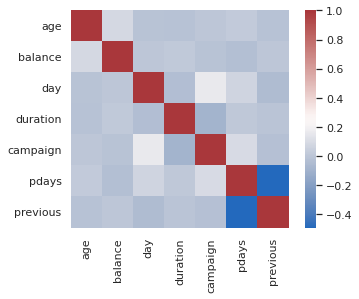

In [200]:
sns.heatmap(corr_mat, square=True, cmap='vlag')
pass

Как и предполагалось, никакой заметной корреляции увидеть не удаётся. Разве что между числом звонков в прошлый раз, и числом дней прошедших с прошлого звонка - 0/365 соответственно для многих клиентов. Эта связь была заведомо известна и никакой новой информации не даёт.

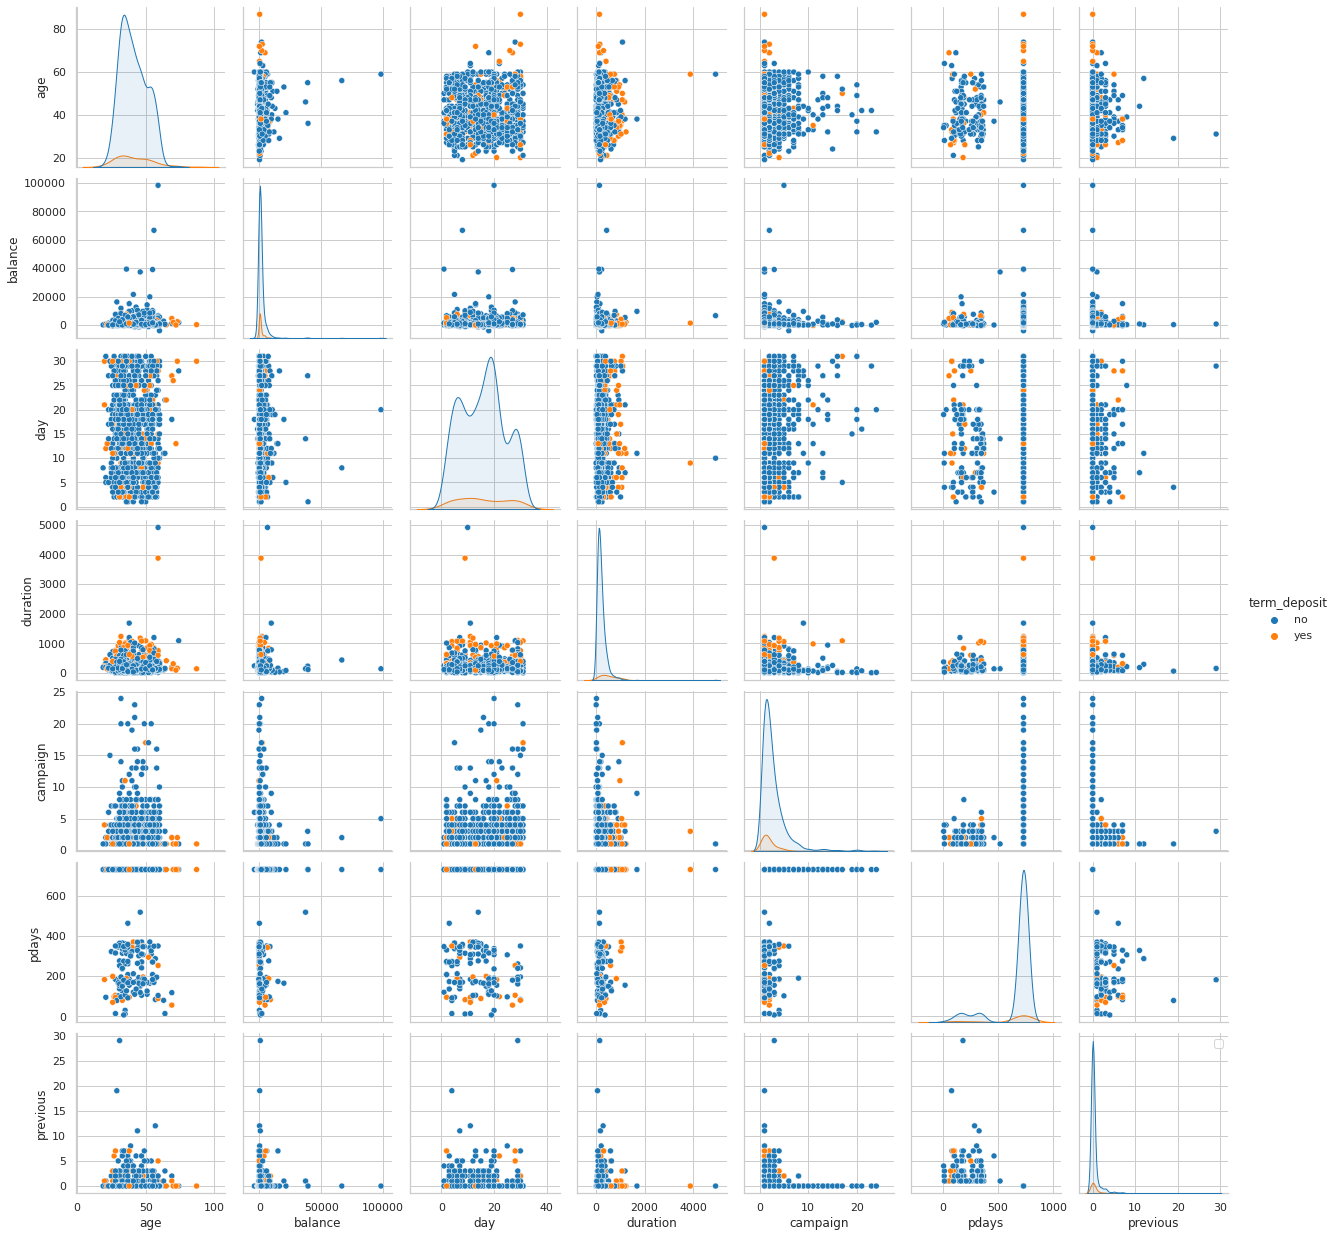

In [201]:
np.random.seed(21)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], diag_kind = 'auto',hue='term_deposit',diag_kws={'alpha':0.1})
plt.legend()
pass

Отсюда видно, что чем более длительным был звонок, тем чаще результатом было согласие. Но воспользоваться этим фактом нельзя, потому что длительность звонка до его совершения неизвестна. Большинству людей либо до этого не звонили ни разу, либо они не стали разговаривать.

Гистограммы возраста и баланса на счёте, а также на их совместное распределение расмоттрим подробнее.

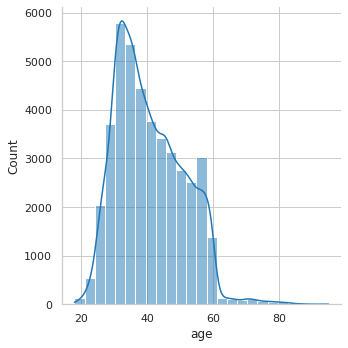

In [202]:
sns.displot(data['age'], bins=25,kde=True)
pass

Людям за 60 банк старается не звонить по вопросу вкладов. Явно виден пик по возрасту, предполагается, что люди около 30 лет более всего заинтересованы во вкладах.

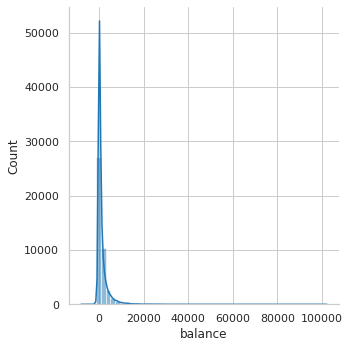

In [203]:
sns.displot(data['balance'], bins=50,kde=True)
pass

Гистограмма баланса похожа на гамма-распределение по своему виду. Явно выделяется пик - у большинства клиентов, которым звонили, баланс на счёте нулевой.

Теперь посмотрим на статистику, связанную с категориальными признаками.

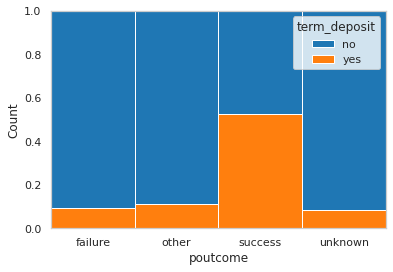

In [204]:
sns.histplot(x='poutcome',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

На данной гистограмме заметна сильная связь между прошлым согласием и текущим согласием. Второй раз люди делают вклад в 4 раза
охотнее.

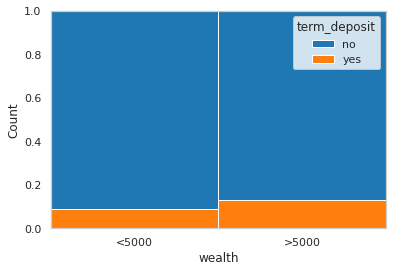

In [205]:
def wealthy (row):
    if (row['balance'] > 5000):
        return '>5000'
    else:
        return '<5000'
data['wealth'] = data.apply (lambda row: wealthy(row), axis=1)
sns.histplot(x='wealth',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
data = data.drop('wealth',  axis=1)
pass

Люди с большим количеством денег делают больше вкладов, это вполне очевидно. 

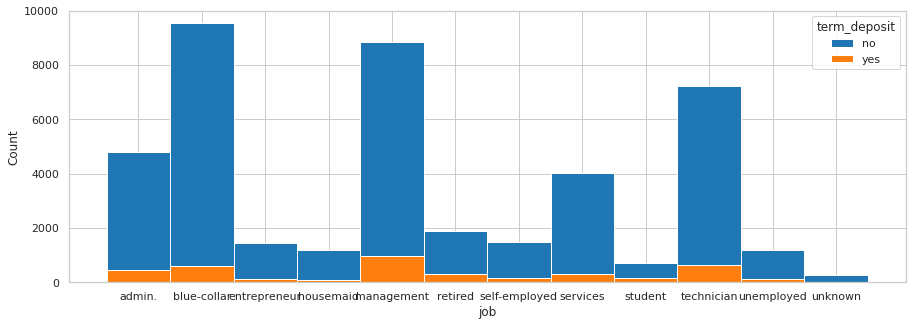

In [206]:
plt.figure(figsize=(15,5))
sns.histplot(x='job',hue='term_deposit',data=data,multiple = 'stack',alpha = 1)
pass

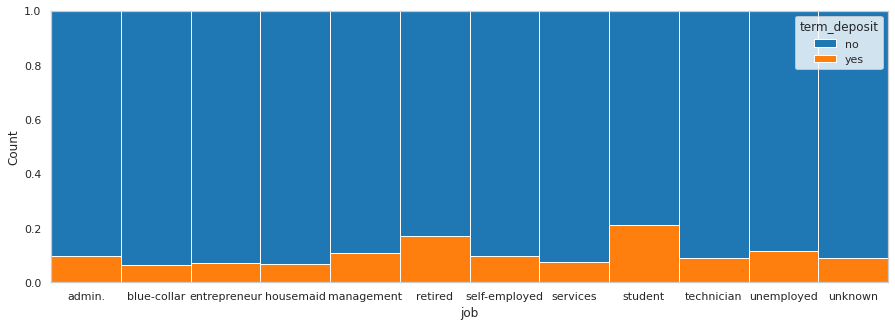

In [207]:
plt.figure(figsize=(15,5))
sns.histplot(x='job',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

На двух гистограммах выше видно, что в банке чаще стараются звонить клиентам, занятым на реальной работе, а предпринимателям, домохозяйкам, пенсионерам, самозанятым, студентам звонят значительно реже. 
 
Но банку следует чаще звонить пенсионерам и студенам, поскольку на вклады они соглашаются почти в два раза чаще, чем остальные.

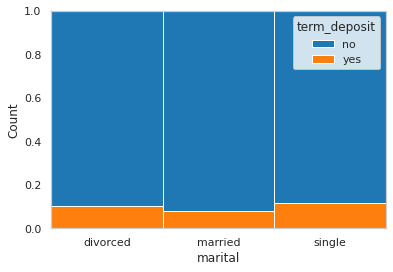

In [208]:
sns.histplot(x='marital',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

От семейного статуса зависимость незначительная.

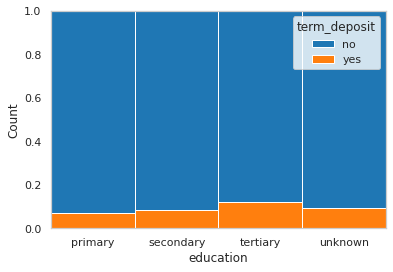

In [209]:
sns.histplot(x='education',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

Люди с более высоким уровнем образования чаще соглашаются на вклад.

## 3. Обработка выбросов
Из всех числовых признаков только возраст и баланс счёта могут обладать выбросами, построим диаграмму рассеивания:

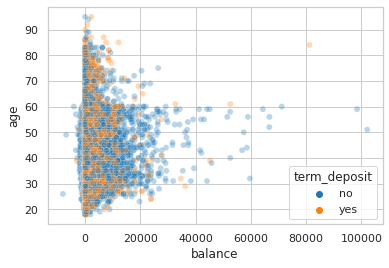

In [210]:
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.3,data = data)
pass

Видим, что выбросы есть для баланса, уберём 0.1% граничных данных для баланса и построим диаграмму рассеивания заново:

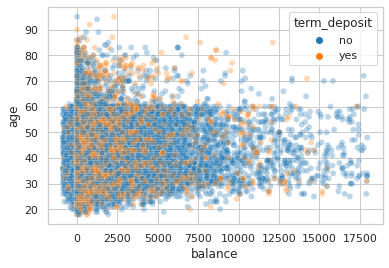

In [211]:
rows_to_drop = data[
    (data['balance'] < data['balance'].quantile(0.005)) | (data['balance'] > data['balance'].quantile(0.995))].index
data = data.drop(rows_to_drop)
data.shape
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.3,data = data)
pass

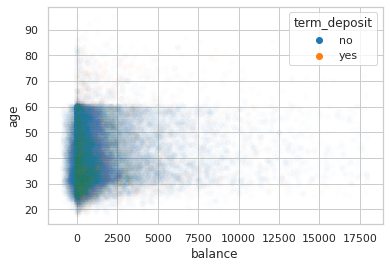

In [212]:
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.01,data = data)
pass

Какой-либо зависимости между возрастом и балансом на счёте проследить не удаётся. По диаграмме можно сделать вывод, что у людей возрастом старше 60 лет меньше денег на счете, но этот вывод ошибочный, потому что количество звонков данной категории людей значительно меньше.

По диаграммам также видно, что ни у одного человека старше 60 лет нет отрицательного баланса. Скорее всего, им просто не звонили.

## 4. Обработка пропущенных значений

Заменим пропущенные значения категориальных признаков 'job', 'education', 'contact' на соответствующие моды:

In [213]:
data.replace({'job':"unknown"}, {'job':data['job'].mode().iloc[0]}, inplace=True)
data.replace({'education':"unknown"},
             {'education':data['education'].mode().iloc[0]}, inplace=True)
data.replace({'contact':"unknown"},
             {'contact':data['contact'].mode().iloc[0]}, inplace=True)
for col in ['job', 'education', 'contact']:
    data[col].cat.remove_unused_categories(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


При этом категорию 'unknown' признака 'poutcome' оставим без изменений, так как замена на моду может повлиять на результат.

## 5. Обработка категориальных признаков
Закодируем бинарные признаки с помощью числовых:

In [214]:
data['default'] = pd.factorize(data['default'], sort = True)[0]
data['housing'] = pd.factorize(data['housing'],sort = True)[0]
data['loan'] = pd.factorize(data['loan'],sort = True)[0]
data['term_deposit'] = pd.factorize(data['term_deposit'],sort = True)[0]

Оставшиеся категориальные признаки закодируем с помощью метода бинаризации:

In [215]:
for col in ['job', 'marital', 'education', 'contact', 'month','poutcome']:
    dummies = pd.get_dummies(data[col])
    data = pd.concat((data, dummies), axis=1)
    data = data.drop([col],  axis=1)

## 6. Нормализация признаков
Выполним стандартизацию всех признаков:

In [216]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

# Решение задачи классификации

## 7. Разбиение на обучающую и тестовую выборки

In [225]:
X = data_stand.drop(['term_deposit','duration'], axis=1)
y = data[['term_deposit']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

## 8. Классификатор kNN

Переберём значения параметра количества соседей в этом алгоритме. Наименьшая ошибка кросс-валидации покажет наилуший выбор параметра количества соседей для метода.

In [226]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

grid = GridSearchCV(KNeighborsClassifier(), param_grid = {'n_neighbors': range(10, 11)})
grid.fit(X_train, y_train.values.ravel())

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors

print('Ошибка на кросс-валидации: ', best_cv_err)
print('Оптимальное количество соседей: ', best_n_neighbors)

Ошибка на кросс-валидации:  0.09210944791010722
Оптимальное количество соседей:  10


Оптимальное количество соседей - 10.

Обучим и запустим метод kNN для этого числа соседей.

In [227]:
%%time

knn = KNeighborsClassifier()

knn.set_params(n_neighbors = best_n_neighbors)
knn.fit(X_train, y_train.values.ravel())
y_predict = knn.predict(X_test)

CPU times: user 7.85 s, sys: 439 ms, total: 8.29 s
Wall time: 6.7 s




Посмотрим confusion matrix для лучшей по точности модели из 10 соседей:

In [228]:
print(confusion_matrix(y_test,y_predict,normalize='true'))

[[0.99186059 0.00813941]
 [0.89484536 0.10515464]]


Почти всегда предполагается, что вклад не взят, и этот исход предсказывается идеально. При дальнейшем увеличении числа соседей, мы всегда будем предсказывать отказ. Но намного выгоднее предсказывать согласие чаще и ошибаться с несогласием, ведь таким образом, банк будет получать больше вкладов, а следовательно больше выгоды для себя, ценой нескольких безрезультатных звонков.

In [229]:
%%time

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train.values.ravel())
print(confusion_matrix(y_test,knn.predict(X_test),normalize='true'))

[[0.92246687 0.07753313]
 [0.79587629 0.20412371]]
CPU times: user 5.24 s, sys: 397 ms, total: 5.63 s
Wall time: 4.11 s


Просмотрим ту же матрицу для модели из 1 соседа. Несмотря на снижение точности мы предсказываем почти в два раза больше согласий, что делает эту модель предпочтительнее.

## 9. Классификатор Random Forest

In [230]:
%%time

rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())
print(confusion_matrix(y_test,rf.predict(X_test),normalize='true'))

[[0.98977356 0.01022644]
 [0.87216495 0.12783505]]
CPU times: user 4.74 s, sys: 9.67 ms, total: 4.75 s
Wall time: 4.74 s


In [231]:
%%time

1-rf.score(X_train, y_train.values.ravel()), 1-rf.score(X_test, y_test.values.ravel())

CPU times: user 1.38 s, sys: 4.15 ms, total: 1.39 s
Wall time: 1.39 s


(6.317518478737849e-05, 0.08945323604662181)

Классификатор обладает той же проблемой, которая описана выше.

## 10. Классификатор Extremely Randomized Trees

In [232]:
%%time

ert = ExtraTreesClassifier(n_estimators = 100)
ert.fit(X_train, y_train.values.ravel())

print(confusion_matrix(y_test,ert.predict(X_test),normalize='true'))

[[0.9787123  0.0212877 ]
 [0.85051546 0.14948454]]
CPU times: user 5 s, sys: 17.3 ms, total: 5.01 s
Wall time: 5.01 s


При использовании ERT точность чуть ниже, но согласий предсказано больше, чем в kNN с 10 соседями.

## 11. Классификатор GBT

In [233]:
%%time

gbt = GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train.values.ravel())

print(confusion_matrix(y_test,gbt.predict(X_test),normalize='true'))

[[0.99144318 0.00855682]
 [0.87525773 0.12474227]]
CPU times: user 5.91 s, sys: 9.98 ms, total: 5.92 s
Wall time: 5.97 s


Применение GBT практически аналогично применению kNN.

## 12. Борьба с несбалансированностью

Для повышения точности предсказания согласия, модифицируем тренировочный датасет таким образом, чтобы в нём было равное распределение по классам.

На диаграмме отражено изначальное распределение классов.

((34440, 44), (34440, 1))

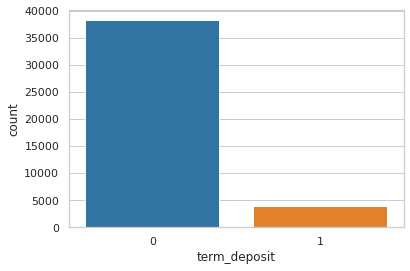

In [234]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
sns.countplot(x = 'term_deposit', data = y)
smote = SMOTE(sampling_strategy=0.2)
X_os, y_os = smote.fit_resample(X_train, y_train.values.ravel())
X_os, y_os = RandomUnderSampler(sampling_strategy=0.2).fit_resample(X_os, y_os)
X_os = pd.DataFrame(X_os)
y_os = pd.DataFrame(y_os)

(X_os.shape,y_os.shape)

Теперь повторим опыт:

In [235]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier()

for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_os, y_os.values.ravel())
    print(f'Соседи - {i}')
    print(f'Train score - {knn.score(X_os, y_os)}')
    print(f'Test score - {knn.score(X_test, y_test)}')
    print(confusion_matrix(y_test,knn.predict(X_test),normalize='true'))
    print('-------------------------------')

Соседи - 1
Train score - 1.0
Test score - 0.8490476641713257
[[0.91297089 0.08702911]
 [0.78247423 0.21752577]]
-------------------------------
Соседи - 2
Train score - 0.9530778164924506
Test score - 0.8844878233677628
[[0.95982469 0.04017531]
 [0.85979381 0.14020619]]
-------------------------------
Соседи - 3
Train score - 0.9346399535423926
Test score - 0.8607031175968919
[[0.92309298 0.07690702]
 [0.7556701  0.2443299 ]]
-------------------------------
Соседи - 4
Train score - 0.912137049941928
Test score - 0.8870463375343505
[[0.95805071 0.04194929]
 [0.81443299 0.18556701]]
-------------------------------
Соседи - 5
Train score - 0.9057200929152148
Test score - 0.8712214536150857
[[0.93248461 0.06751539]
 [0.73402062 0.26597938]]
-------------------------------
Соседи - 6
Train score - 0.8902729384436702
Test score - 0.8920686060835781
[[0.96013774 0.03986226]
 [0.78041237 0.21958763]]
-------------------------------
Соседи - 7
Train score - 0.888704994192799
Test score - 0.8835

В данном случае лучшим оказывается классификатор с числом соседей, равным 7. Он предсказывает 25.1% согласий и имеет общую точность 87.47%.

In [236]:
rf = RandomForestClassifier()
rf.fit(X_os, y_os.values.ravel())

print("Train score - ", rf.score(X_os, y_os))
print("Test score - ", rf.score(X_test, y_test))
print(confusion_matrix(y_test,rf.predict(X_test),normalize='true'))

Train score -  0.9999419279907085
Test score -  0.9079882497867905
[[0.98413858 0.01586142]
 [0.8443299  0.1556701 ]]


Random Forest на сбалансированном датасете работает несколько хуже, чем kNN с числом соседей 7.

In [237]:
ert = ExtraTreesClassifier(n_estimators = 100)
ert.fit(X_os, y_os.values.ravel())

print("Train score - ", ert.score(X_os, y_os))
print("Test score - ", ert.score(X_test, y_test))
print(confusion_matrix(y_test,ert.predict(X_test),normalize='true'))

Train score -  1.0
Test score -  0.9006917464228181
[[0.97432954 0.02567046]
 [0.82680412 0.17319588]]


ERT показывает себя лучше, чем RF, но все еще хуже, чем kNN с числом соседей 7.

In [238]:
gbt = GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_os, y_os.values.ravel())

print("Train score - ", gbt.score(X_os, y_os))
print("Test score - ", gbt.score(X_test, y_test))
print(confusion_matrix(y_test,gbt.predict(X_test),normalize='true'))

Train score -  0.897444831591173
Test score -  0.9110205628731166
[[0.98956485 0.01043515]
 [0.86494845 0.13505155]]


Gradient Boosting же показывает самые плохие результаты.

Также в качестве эксперимента используем модели, где для классов указывается вес, в зависимости от их соотношения.

In [239]:
rf_balanced = RandomForestClassifier(n_estimators=150, class_weight='balanced')
rf_balanced.fit(X_train, y_train.values.ravel())
print(confusion_matrix(y_test,rf_balanced.predict(X_test),normalize='true'))

[[0.99165188 0.00834812]
 [0.89484536 0.10515464]]


In [240]:
from sklearn.svm import SVC
svc_balanced = SVC(kernel='linear', class_weight='balanced')
svc_balanced.fit(X_train, y_train.values.ravel())
print(confusion_matrix(y_test,svc_balanced.predict(X_test),normalize='true'))

[[0.84983826 0.15016174]
 [0.59072165 0.40927835]]


In [241]:
np.mean(svc_balanced.predict(X_test) == np.array(y_test).ravel())

0.8093433146972425

Сбалансированный SVM оказывается наилучшим классификатором с точностью 40.4%.

## 13. Метод главных компонент (PCA)

Метод главных компонент (PCA) нужен для уменьшения размерности данных.

In [242]:
print('N Components | Train score | Test score | Accepted score')
for i in range(1,20):
    pca = PCA(n_components = i)
    res = pca.fit(X).transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(res, y, test_size = 0.25,
                                              random_state = 22)
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn.fit(X_tr, y_tr.values.ravel())
    print(f'{i} {knn.score(X_tr, y_tr)} {knn.score(X_te, y_te)} \
      {confusion_matrix(y_te,knn.predict(X_te),normalize="true")[1,1]}')

N Components | Train score | Test score | Accepted score
1 0.9078589929875545 0.9041030986449351       0.011190233977619531
2 0.910070124455114 0.9005022268549228       0.024415055951169887
3 0.9104807631562323 0.9031555008054581       0.04069175991861648
4 0.9129130077705477 0.9047664171325689       0.0681586978636826
5 0.914081748689115 0.9071354117312612       0.08952187182095625
6 0.9147450881293828 0.9061878138917844       0.10071210579857579
7 0.9149662012761387 0.9040083388609874       0.0844354018311292
8 0.9146503253522017 0.9042926182128305       0.08646998982706001
9 0.9149030260913513 0.9074196910831044       0.11597151576805696
10 0.9146819129445953 0.9073249312991566       0.10579857578840285
11 0.9158822414555563 0.9067563725954705       0.11597151576805696
12 0.9163560553414619 0.9074196910831044       0.11495422177009156
13 0.9166403436730053 0.9086515682744243       0.12919633774160733
14 0.9161981173794933 0.9076092106509998       0.12105798575788403
15 0.91717733274

# Выводы

В результате работы над первой частью можно сделать следующие выводы: (кроме тех, что были сделаны ранее)

- Наиболее важным является не повышение общей точности предсказания, а правильность предсказания согласия.
- В этой задаче важная роль отводится случайному фактору, а все данные, что имеются у банка, не сильно влияют на исход звонка, что дает малую точность предсказаний согласия.
- Борьба с несбалансированностью классов поднимает точность предсказания согласий на 6% в лучшем случае, а общую точность на 2%, что не является большим достижением.
- Лучший классификатор для данной задачи - сбалансированный SVM с точностью предсказания 40.4%.
- Точки, соответствующие согласиям, редко собираются в кластеры и расположены произвольно во всей массе точек, потому что точность их предсказания не превышает 12%.
- Метод сокращения размерности в целом плохо подходит для этой задачи, точность предсказания согласия существенно ниже, а в лучшем случае не превышает 15%. При этом общая точность вообще практически не меняется при изменении числа компонент.
- Точность предскания при использовании PCA падает, что говорит о важности всех признаков.